In [1]:
import requests
import json
import os
from pathlib import Path

from tqdm import tqdm

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
# import ffmpeg

from detector.mrcnn import visualize
import detector.mrcnn.model as modellib

import lego

from tracker.deep_sort import preprocessing
from tracker.deep_sort import nn_matching
from tracker.deep_sort.detection import Detection
from tracker.deep_sort.tracker import Tracker
from tracker.deep_sort import generate_detections


# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
tf.__version__

'2.5.1'

In [2]:
model_feature = os.path.join('weights', 'mars-small128.pb')
# model_feature = 'market1501.pb'
min_score = 0.7

encoder = generate_detections.create_box_encoder(model_feature, batch_size=1)
metric = nn_matching.NearestNeighborDistanceMetric("cosine", min_score, None)
tracker = Tracker(metric)

In [3]:
import os
from PIL import Image, ImageDraw, ImageFont

def render_detections(image, boxes, masks, class_ids, scores, class_names, image_name=None, filter_classs_names=None,
               scores_thresh=0.1, save_dir=None, mode=0):
    """
        image: image array
        image_name: image name
        boxes: [num_instance, (y1, x1, y2, x2, class_id)] in image coordinates.
        masks: [num_instances, height, width]
        class_ids: [num_instances]
        scores: confidence scores for each box
        class_names: list of class names of the dataset
        filter_classs_names: (optional) list of class names we want to draw
        scores_thresh: (optional) threshold of confidence scores
        save_dir: (optional) the path to store image
        mode: (optional) select the result which you want
                mode = 0 , save image with bbox,class_name,score and mask;
                mode = 1 , save image with bbox,class_name and score;
                mode = 2 , save image with class_name,score and mask;
                mode = 3 , save mask with black background;
    """
    mode_list = [0, 1, 2, 3]
    assert mode in mode_list, "mode's value should in mode_list %s" % str(mode_list)

    if save_dir is None and image_name is not None:
        save_dir = os.path.join(os.getcwd(), "output")
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)

    useful_mask_indices = []

    N = boxes.shape[0]
    if not N:
        print("\n*** No instances in image %s to draw *** \n" % (image_name))
        return
    else:
        assert boxes.shape[0] == masks.shape[-1] == class_ids.shape[0]

    for i in range(N):
        # filter
        class_id = class_ids[i]
        score = scores[i] if scores is not None else None
        if score is None or score < scores_thresh:
            continue

        label = class_names[class_id]
        if (filter_classs_names is not None) and (label not in filter_classs_names):
            continue

        if not np.any(boxes[i]):
            # Skip this instance. Has no bbox. Likely lost in image cropping.
            continue

        useful_mask_indices.append(i)

    if len(useful_mask_indices) == 0:
        print("\n*** No instances in image %s to draw *** \n" % (image_name))
        return

    colors = visualize.random_colors(len(useful_mask_indices))

    if mode != 3:
        masked_image = image.astype(np.uint8).copy()
    else:
        masked_image = np.zeros(image.shape).astype(np.uint8)

    if mode != 1:
        for index, value in enumerate(useful_mask_indices):
            masked_image = visualize.apply_mask(masked_image, masks[:, :, value], colors[index])

    masked_image = Image.fromarray(masked_image)

    if mode == 3:
        if image_name is not None:
            masked_image.save(os.path.join(save_dir, '%s.jpg' % (image_name)))
        return masked_image

    draw = ImageDraw.Draw(masked_image)
    colors = np.array(colors).astype(int) * 255

    for index, value in enumerate(useful_mask_indices):
        class_id = class_ids[value]
        score = scores[value]
        label = class_names[class_id]

        y1, x1, y2, x2 = boxes[value]
        if mode != 2:
            color = tuple(colors[index])
            draw.rectangle((x1, y1, x2, y2), outline=color)

        # Label
        # font = ImageFont.truetype('/Library/Fonts/Arial.ttf', 15)
        # draw.text((x1, y1), "%s %f" % (label, score), (255, 255, 255), font)
        draw.text((x1, y1), "%s %f" % (label, score), (255, 255, 255))

    if image_name is not None:
        masked_image.save(os.path.join(save_dir, '%s.jpg' % (image_name)))
    return masked_image

In [4]:
REPO_URL = 'https://api.github.com/repos/LilDataMonster/Lego-CNN/releases/latest'
response = json.loads(requests.get(REPO_URL).text)

In [6]:
LEGO_WEIGHTS_URL = response['assets'][0]['browser_download_url']
LEGO_WEIGHTS_NAME = os.path.basename(LEGO_WEIGHTS_URL)

LEGO_WEIGHTS_PATH = Path(os.path.join('weights', LEGO_WEIGHTS_NAME))

weights_response = requests.get(LEGO_WEIGHTS_URL, stream=True)
total_size_in_bytes= int(weights_response.headers.get('content-length', 0))
progress_bar = tqdm(total=total_size_in_bytes, unit='iB', unit_scale=True)
if not LEGO_WEIGHTS_PATH.exists():
    # Streaming, so we can iterate over the response.
    block_size = 1024 #1 Kibibyte
    with open(LEGO_WEIGHTS_NAME, 'wb') as file:
        for data in weights_response.iter_content(block_size):
            progress_bar.update(len(data))
            file.write(data)

    if total_size_in_bytes != 0 and progress_bar.n != total_size_in_bytes:
        print("ERROR downloading pretrained weights")
progress_bar.close()


  6%|▌         | 15.7M/262M [00:10<02:43, 1.51MiB/s]
  0%|          | 0.00/262M [00:00<?, ?iB/s]


In [6]:
class InferenceConfig(lego.LegoConfig().__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()

In [7]:
# # Directory to save logs and trained model
# MODEL_DIR = os.path.join(ROOT_DIR, "logs")
# LEGO_WEIGHTS_PATH = os.path.join(ROOT_DIR, "snapshots", "weights","mask_rcnn_lego_0111.h5") # Comment out to use snapshot from latest training

model = modellib.MaskRCNN(mode="inference", model_dir="", config=config)
print("Loading weights ", LEGO_WEIGHTS_PATH)
model.load_weights(LEGO_WEIGHTS_PATH, by_name=True)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Instructions for updating:
Use fn_output_signature instead
Loading weights  mask_rcnn_lego_0200.h5


In [8]:
# dataset = lego.LegoDataset()
# dataset.prepare()
#dataset.class_names
class_names = ['BG', '2431', '3003', '3005', '3010', '3020', '3021', '3022', '3023', '3024', '3069', '3070', '3176', '3622', '3700', '3710', '3958', '4150', '4274', '6141', '11211', '11476', '11477', '15068', '15573', '22885', '24201', '24246', '25269', '29119', '29120', '33909', '35480', '36840', '47458', '47905', '85984', '87079', '87087', '87580', '93273', '98138', '99206']

In [9]:
from tqdm import tqdm
from cv2 import CAP_PROP_FRAME_COUNT

def frame_iter(capture, description):
    def _iterator():
        while capture.grab():
            yield capture.retrieve()[1]
    return tqdm(
        _iterator(),
        desc=description,
        total=int(capture.get(CAP_PROP_FRAME_COUNT)),
    )

In [10]:
import colorsys
import random
def draw_bbox(image, bboxes, CLASSES=class_names, show_label=True, show_confidence = True, Text_colors=(255,255,0), rectangle_colors='', tracking=False):   
#     NUM_CLASS = read_class_names(CLASSES)
    NUM_CLASS = class_names
    num_classes = len(class_names)
    image_h, image_w, _ = image.shape
    hsv_tuples = [(1.0 * x / num_classes, 1., 1.) for x in range(num_classes)]
    #print("hsv_tuples", hsv_tuples)
    colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
    colors = list(map(lambda x: (int(x[0] * 255), int(x[1] * 255), int(x[2] * 255)), colors))

    random.seed(0)
    random.shuffle(colors)
    random.seed(None)

    for i, bbox in enumerate(bboxes):
#         coor = np.array(bbox[:4], dtype=np.int32)
        score = bbox[4]
        class_ind = int(bbox[5])
        bbox_color = rectangle_colors if rectangle_colors != '' else colors[class_ind]
        bbox_thick = int(0.6 * (image_h + image_w) / 1000)
        if bbox_thick < 1: bbox_thick = 1
        fontScale = 0.75 * bbox_thick
#         (x1, y1), (x2, y2) = (coor[0], coor[1]), (coor[2], coor[3])
        y1, x1, y2, x2 = np.array(bbox[:4], dtype=np.int32)

        # put object rectangle
        cv2.rectangle(image, (x1, y1), (x2, y2), bbox_color, bbox_thick*2)
#         cv2.rectangle(image, (x1, y1), ((x2 - x1), (y2 - y1)), bbox_color, bbox_thick*2)

        if show_label:
            # get text label
            score_str = " {:.2f}".format(score) if show_confidence else ""

            if tracking: score_str = " "+str(score)

            label = "{}".format(NUM_CLASS[class_ind]) + score_str

            # get text size
            (text_width, text_height), baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_COMPLEX_SMALL,
                                                                  fontScale, thickness=bbox_thick)
            # put filled text rectangle
            cv2.rectangle(image, (x1, y1), (x1 + text_width, y1 - text_height - baseline), bbox_color, thickness=cv2.FILLED)

            # put text above rectangle
            cv2.putText(image, label, (x1, y1-4), cv2.FONT_HERSHEY_COMPLEX_SMALL,
                        fontScale, Text_colors, bbox_thick, lineType=cv2.LINE_AA)

    return image

In [11]:
colors = visualize.random_colors(len(class_names))
colors = (np.array(colors).astype(float) * 255).astype(int)

In [12]:
video_filename = os.path.join('videos', 'movie_30fps.mp4')
cap = cv2.VideoCapture(video_filename)
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))

detect_video_filename = 'detect_' + os.path.basename(video_filename)
out = cv2.VideoWriter(detect_video_filename, cv2.VideoWriter_fourcc('M','J','P','G'), 60, (frame_width,frame_height))

track_total = []
for frame in frame_iter(cap, detect_video_filename):
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = model.detect([frame], verbose=0)[0]
    
    boxes = results['rois']
    masks = results['masks']
    class_ids = results['class_ids']
    classes_scores = results['scores']

    N = boxes.shape[0]
    return_boxes = []
    return_scores = []
    return_masks = []
    return_class_names = []
    return_class_color = []

    for i in range(N):
        class_id = class_ids[i]
        classes_score = classes_scores[i]

        if classes_score < min_score: continue

        return_scores.append(classes_score)
        y1, x1, y2, x2 = boxes[i]
        return_boxes.append([x1, y1, (x2 - x1), (y2 - y1)])
        return_masks.append(masks[:, :, i])
        return_class_names.append(class_names[class_id])
        return_class_color.append(colors[i])
        
    results['class_colors'] = [colors[cid] for cid in results['class_ids']]

    features = encoder(frame, return_boxes)
    
    detections = []
    for bbox, score, classes, mask, color, feature in zip(results['rois'], results['scores'], results['class_ids'], results['masks'], results['class_colors'], features):
        detections.append(Detection(bbox, score, classes, mask, color, feature))

#     boxes = np.array([d.tlwh for d in detections])
#     scores = np.array([d.confidence for d in detections])
#     indices = preprocessing.non_max_suppression(boxes, 1.0, scores)
#     detections = [detections[i] for i in indices]
        
    # Pass detections to the deepsort object and obtain the track information.
    tracker.predict()
    tracker.update(detections)
    
    # Obtain info from the tracks
    track_count = 0
    tracked_bboxes = []
    for track in tracker.tracks:
        if not track.is_confirmed() or track.time_since_update > 5:
            continue 
#         bbox = track.to_tlbr() # Get the corrected/predicted bounding box
        bbox = track.to_tlwh()
        class_name = track.get_class() # Get the class name of particular object
        tracking_id = track.track_id # Get the ID for the particular track
        
        track_total.append(tracking_id)
        track_count += 1
        
#         index = key_list[val_list.index(class_name)] # Get predicted object index by object name
#         tracked_bboxes.append(bbox.tolist() + [tracking_id, index]) # Structure data, that we could use it with our draw_bbox function

#         index = class_names.index(class_name)
        index = class_name
        tracked_bboxes.append(bbox.tolist() + [tracking_id, index]) # Structure data, that we could use it with our draw_bbox function
        
    # draw detection on frame
    frame_detect = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
    image = draw_bbox(frame_detect, tracked_bboxes, tracking=True)
    
#     output_image = render_detections(frame, results['rois'], results['masks'], results['class_ids'], results['scores'], class_names, filter_classs_names=None, scores_thresh=0.1, save_dir=None, mode=0)
    
#     plt_image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
#     plt.figure(figsize=(24,16))
#     plt.subplot(121)
#     plt.imshow(plt_image)
#     plt.subplot(122)
#     plt.imshow(output_image)
#     plt.show()
    
#     print(bbox)
    
#     break
    
# #     frame_detect = render_detections(frame, results['rois'], results['masks'], results['class_ids'], results['scores'], class_names, filter_classs_names=None, scores_thresh=0.1, save_dir=None, mode=0)
# #     frame_detect = np.array(frame_detect)
    
# #     frame_detect = cv2.cvtColor(frame_detect, cv2.COLOR_RGB2BGR)
    out.write(image)
    
cap.release()    
out.release()

detect_movie_30fps.mp4:   0%|          | 0/525 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:2424: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '
detect_movie_30fps.mp4: 100%|██████████| 525/525 [03:56<00:00,  2.22it/s]


### Debug

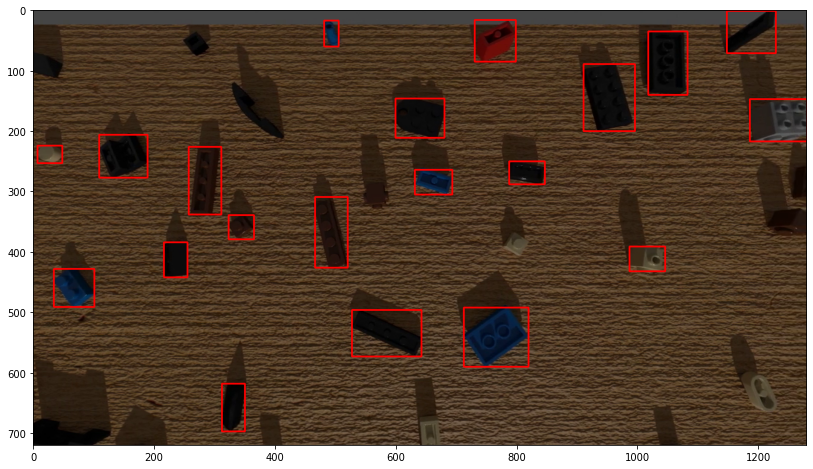

In [13]:
# bbox
bbox = [1067, 311, 213, 254]
tmp_frame = frame.copy()
for bbox in results['rois']:
    coor = np.array(bbox[:4], dtype=np.int32)
#     (x1, y1), (x2, y2) = (coor[0], coor[1]), (coor[2], coor[3])
    (y1, x1), (y2, x2) = (coor[0], coor[1]), (coor[2], coor[3])
    cv2.rectangle(tmp_frame, (x1, y1), (x2, y2), [255, 0, 0], 2)

plt.figure(figsize=(16,8))
plt.imshow(tmp_frame)

In [ ]:
tmp_frame = frame.copy()
for det in detections:
#     y1, x1, y2, x2 = np.array(det.to_tlbr(), dtype=np.int32)
    y1, x1, y2, x2 = np.array(det.tlwh, dtype=np.int32)
    
    cv2.rectangle(tmp_frame, (x1, y1), (x2, y2), [255, 0, 0], 2)
#     cv2.rectangle(tmp_frame, (x1, y1), ((x2 - x1), (y2 - y1)), [255, 0, 0], 2)
    
plt.figure(figsize=(16,8))
plt.imshow(tmp_frame)

In [ ]:
tmp_frame = frame.copy()
for bbox in tracked_bboxes:
#     y1, x1, y2, x2 = np.array(det.to_tlbr(), dtype=np.int32)
    y1, x1, y2, x2 = np.array(bbox[:4], dtype=np.int32)
    cv2.rectangle(tmp_frame, (x1, y1), (x2, y2), [255, 0, 0], 2)
    
#     cv2.rectangle(tmp_frame, (x1, y1), ((x2 - x1), (y2 - y1)), [255, 0, 0], 2)
    
plt.figure(figsize=(16,8))
plt.imshow(tmp_frame)